<h4>CSE-6363-002: Machine Learning</h4>
<h5>HomeWork 2</h5>
<h5>Team 6:</h5>


In [ ]:
#Imports
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [ ]:
#Loading the CIFAR10 Dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                        transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,
                                          num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170498071/170498071 [00:13<00:00, 13086945.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


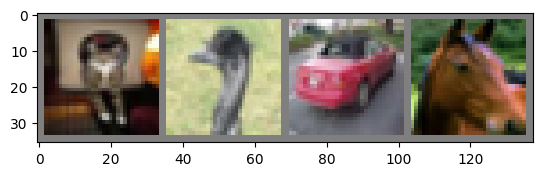

cat   bird  car   horse


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
def prepare_data(trainset, val_split=0.1):
    # Convert CIFAR-10 images to numpy arrays and flatten them
    X = np.array([np.ravel(trainset[i][0].numpy()) for i in range(len(trainset))])
    y = np.array([trainset[i][1] for i in range(len(trainset))])

    # Split dataset into training and validation sets (90% train, 10% validation)
    split_size = int((1 - val_split) * len(trainset))
    indices = np.random.permutation(len(trainset))

    train_indices = indices[:split_size]
    val_indices = indices[split_size:]

    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    return X_train.T, X_val.T, y_train, y_val  # Transpose to get the correct shape for input

X_train, X_val, y_train, y_val = prepare_data(trainset)


In [ ]:

# Function to load and preprocess CIFAR-10 data
def load_and_preprocess_cifar10(trainset, testset):
    # Convert to numpy arrays
    X_train = np.array([img.numpy().flatten() for img, _ in trainset])
    y_train = np.array([label for _, label in trainset])
    X_test = np.array([img.numpy().flatten() for img, _ in testset])
    y_test = np.array([label for _, label in testset])

    # Split training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Transpose the data to match the expected shape (features, samples)
    X_train = X_train.T
    X_val = X_val.T
    X_test = X_test.T

    return X_train, y_train, X_val, y_val, X_test, y_test

# Function to calculate accuracy (outside of the class)
def calculate_accuracy(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = np.mean(predictions == y_test) * 100
    return accuracy

In [ ]:
print(f"Printing the 5 entries of the trainset_numpy array: {X_train[:5]}")
print(f"Display the size of the trainset_numpy{X_train.shape}")

Printing the 5 entries of the trainset_numpy array: [[ 0.99215686  0.12941182 -1.         ...  0.24705887  1.
  -0.00392157]
 [ 0.99215686  0.1686275  -1.         ...  0.26274514  0.99215686
  -0.01176471]
 [ 0.96862745  0.26274514 -1.         ...  0.27843142  1.
   0.00392163]
 [ 0.94509804  0.30980396 -1.         ...  0.2941177   1.
   0.02745104]
 [ 0.92941177  0.33333337 -1.         ...  0.32549024  0.99215686
   0.03529418]]
Display the size of the trainset_numpy(3072, 45000)


In [ ]:
class NeuralNetwork:
  def __init__(self, layer_dimensions):
    self.layer_dimensions = layer_dimensions
    np.random.seed(1)
    self.parameters = {}
    layer_dimensions_len = len(layer_dimensions)
    for i in range(1, layer_dimensions_len):
        self.parameters["W" + str(i)] = np.random.randn(self.layer_dimensions[i], self.layer_dimensions[i - 1]) * 0.01
        self.parameters["b" + str(i)] = np.random.randn(self.layer_dimensions[i], 1)

  def affineForward(self, A, W, b):
      Z = np.dot(W, A) + b
      cache = (A, W, b)
      return Z, cache

  def activationForward(self, A):
      Z = np.maximum(0, A)
      cache = A
      return Z

  def forwardPropagation(self, X):
      caches = []
      A = X
      L = len(self.parameters) // 2

      for i in range(1, L + 1):
        A_prev = A
        Z, affine_cache = self.affineForward(A_prev, self.parameters["W" + str(i)], self.parameters["b" + str(i)])
        A = self.activationForward(Z)

        caches.append((affine_cache, Z))

      return A, caches

  def costFunction(self, AL, y):
      m = y.shape[0]
      exp_values = np.exp(AL - np.max(AL, axis=0, keepdims=True))
      probs = exp_values / np.sum(exp_values, axis=0, keepdims=True)
      log_probs = -np.log(probs[y, np.arange(m)])
      cost = np.sum(log_probs) / m
      return cost, probs

  def affineBackward(self, dA_prev, cache):
      A_prev, W, b = cache
      m = A_prev.shape[1]
      dW = np.dot(dA_prev, A_prev.T) / m
      db = np.sum(dA_prev, axis=1, keepdims=True) / m
      dA_prev = np.dot(W.T, dA_prev)
      return dA_prev, dW, db

  def activationBackward(self, dA, cache):
      Z = cache
      dZ = np.array(dA, copy=True)
      dZ[Z <= 0] = 0
      return dZ

  def backPropagation(self, dAL, Y, cache):
    gradients = {}
    cache_len = len(cache)
    m = dAL.shape[1]

    Y_one_hot = np.zeros((dAL.shape[0], m))
    Y_one_hot[Y, np.arange(m)] = 1

    dAL = dAL - Y_one_hot

    current_cache, ZL = cache[cache_len - 1]
    gradients['dA' + str(cache_len - 1)], gradients['dW' + str(cache_len)], gradients['db' + str(cache_len)] = self.affineBackward(dAL, current_cache)

    for l in reversed(range(cache_len-1)):
          current_cache, activation_cache = cache[l]
          dA_prev_temp = gradients['dA' + str(l+1)]
          dZ_temp = self.activationBackward(dA_prev_temp, activation_cache)
          gradients['dA' + str(l)], gradients['dW' + str(l+1)], gradients['db' + str(l+1)] = self.affineBackward(dZ_temp, current_cache)

    return gradients

  def updateParameters(self, gradients, alpha):
      L = len(self.parameters) // 2
      for l in range(1, L + 1):
          self.parameters['W' + str(l)] -= alpha * gradients['dW' + str(l)]
          self.parameters['b' + str(l)] -= alpha * gradients['db' + str(l)]

  def evaluate(self, AL, y):
    predictions = np.argmax(AL, axis=0)
    accuracy = np.mean( predictions == y) * 100
    return accuracy


  def train(self, X_train, y_train, X_val, y_val, iters, alpha, batch_size):
    m = X_train.shape[1]
    costs = []
    train_accuracies = []
    val_accuracies = []

    for i in range(iters):
        total_cost = 0
        num_batches = 0
        for j in range(0, m, batch_size):
            X_batch = X_train[:, j:j + batch_size]
            y_batch = y_train[j:j + batch_size].astype(int)

            AL, caches = self.forwardPropagation(X_batch)

            cost, probs = self.costFunction(AL, y_batch)
            total_cost = total_cost + cost
            num_batches = num_batches + 1

            gradients = self.backPropagation(probs, y_batch, caches)

            self.updateParameters(gradients, alpha)

            average_cost = total_cost / num_batches

        if i % 10 == 0:
            AL_train, _ = self.forwardPropagation(X_train)
            train_accuracy = self.compute_accuracy(AL_train, y_train)

            AL_val, _ = self.forwardPropagation(X_val)
            val_accuracy = self.compute_accuracy(AL_val, y_val)

            print(f"Iteration {i}: Average Cost = {average_cost:.4f}, Training Accuracy = {train_accuracy:.2f}%, Validation Accuracy = {val_accuracy:.2f}%")

            costs.append(average_cost)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
    return costs, train_accuracies, val_accuracies

  def compute_accuracy(self, AL, y):
    predictions = np.argmax(AL, axis=0)
    accuracy = np.mean(predictions == y) * 100
    return accuracy

  def predict(self, X_new):
    AL, _ = self.forwardPropagation(X_new)
    predictions = np.argmax(AL, axis=0)
    return predictions


In [ ]:
# Load and preprocess CIFAR-10 data
X_train_n, y_train_n, X_val_n, y_val_n, X_test_n, y_test_n = load_and_preprocess_cifar10(trainset, testset)

# Initialize the neural network
input_size = X_train_n.shape[0]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 128
output_size = 10
layer_dimensions = [input_size, hidden_size1, hidden_size2, hidden_size3, output_size]
nn_model = NeuralNetwork(layer_dimensions)



In [ ]:
costs, train_accuracies, val_accuracies = nn_model.train(X_train_n, y_train_n, X_val_n, y_val_n, iters=300, alpha=0.01, batch_size=256)

Iteration 0: Average Cost = 2.3214, Training Accuracy = 9.96%, Validation Accuracy = 10.40%
Iteration 10: Average Cost = 2.3006, Training Accuracy = 12.37%, Validation Accuracy = 12.36%
Iteration 20: Average Cost = 2.0626, Training Accuracy = 20.25%, Validation Accuracy = 20.08%
Iteration 30: Average Cost = 2.0179, Training Accuracy = 21.88%, Validation Accuracy = 21.10%
Iteration 40: Average Cost = 1.9757, Training Accuracy = 24.42%, Validation Accuracy = 23.80%
Iteration 50: Average Cost = 1.8173, Training Accuracy = 32.60%, Validation Accuracy = 31.92%
Iteration 60: Average Cost = 1.7271, Training Accuracy = 36.40%, Validation Accuracy = 35.22%
Iteration 70: Average Cost = 1.6326, Training Accuracy = 40.50%, Validation Accuracy = 39.48%
Iteration 80: Average Cost = 1.5376, Training Accuracy = 44.01%, Validation Accuracy = 42.72%
Iteration 90: Average Cost = 1.4394, Training Accuracy = 47.63%, Validation Accuracy = 45.52%
Iteration 100: Average Cost = 1.3539, Training Accuracy = 50.7

In the above iterations logs, the Average cost is nothing but the Loss. And Also we can see that as the Average cost is decreasing then the validation accuracy is increasing.

Our Validation and Testing Accuracy is also greater than random guessing. As there are 10 classesfor classification the random gussing will be 10%. (If we take the example of the binary classifier the random gussessing will be 50%).

In [ ]:
# Calculate and print val accuracy
val_y_pred = nn_model.predict(X_val_n)
val_accuracy = np.mean(val_y_pred == y_val_n) * 100

# val_accuracy = compute_accuracy(, X_val_n, y_val_n)
print(f"Val Accuracy: {val_accuracy:.2f}%")

Val Accuracy: 48.88%


In [ ]:
# Calculate and print test accuracy
test_y_pred = nn_model.predict(X_test_n)
test_accuracy = np.mean(test_y_pred == y_test_n) * 100


print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 49.87%


In [ ]:
def plot_evaluation(iterations, costs, val_accuracies):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting the average cost
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Average Cost', color='blue')
    ax1.plot(iterations, costs, label='Average Cost', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Creating a second y-axis for validation accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='green')
    ax2.plot(iterations, val_accuracies, label='Validation Accuracy', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Title and legend
    plt.title('Average Cost and Validation Accuracy vs Iterations')
    fig.tight_layout()  # Adjust layout to prevent clipping of ylabel
    plt.show()


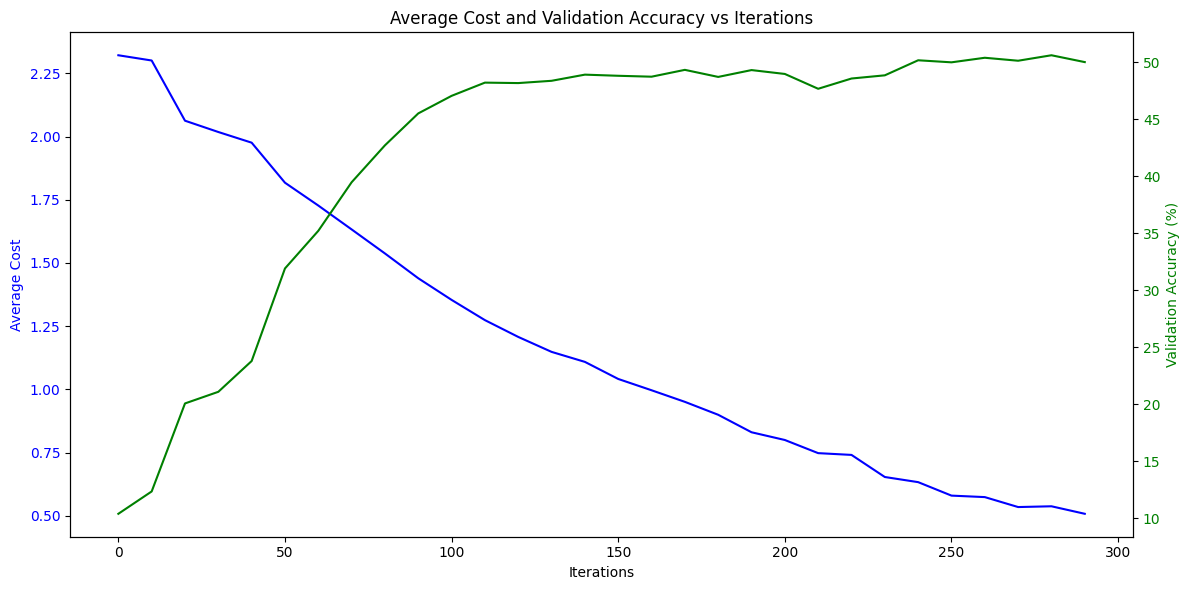

In [ ]:
# Create the iterations array
iterations = list(range(0, len(train_accuracies) * 10, 10))
plot_evaluation(iterations, costs, val_accuracies)

In [ ]:
def predict_image_labels_ann(features, model):
  pred = []
  images = []
  for i in range(features.shape[1]):
    image = features[:, i]
    outputs = model.predict(image)
    predicted = np.argmax(outputs, axis=0) # np.max(outputs, 1)
    pred.append(predicted)
    images.append(image)

  return images, pred

In [ ]:
def display_images_with_labels(images, labels, classes):

  num_images = images.shape[1]
  rows = (num_images + 4) // 5
  fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))

  for i in range(num_images):
    image = images[:, i].reshape(32, 32, 3)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Predicted: {classes[labels[i][0]]}")
    axes[row, col].axis('off')

  for i in range(num_images, rows * 5):
    row = i // 5
    col = i % 5
    fig.delaxes(axes[row, col])

  plt.tight_layout()
  plt.show()


num_images_to_display = 6
images_to_display = X_test_n[:, :num_images_to_display]

predicted_labels = nn_model.predict(images_to_display)

display_images_with_labels(images_to_display, [[label] for label in predicted_labels], classes)


In [ ]:
image = 5
def display_predictions_ann(images, predicted, model, image):
  plt.figure(figsize=(12,8))

  for i in range(min(image, len(images))):
    plt.subplot(4,i + 1)
    image_temp = images[i] # np.transpose(image,(1,2,0))
    # imshow_ann(image_temp)
    imshow_ann(torchvision.utils.make_grid(image_temp))
    plt.title(f"{model} Predicted: {classes[predicted[i].item()]}")
    plt.axis('off')
  plt.tight_layout()
  plt.axis()

In [ ]:
images, pred = predict_image_labels_ann(X_test_n[:, :1], nn_model)

In [ ]:
images[0].shape

(3072,)

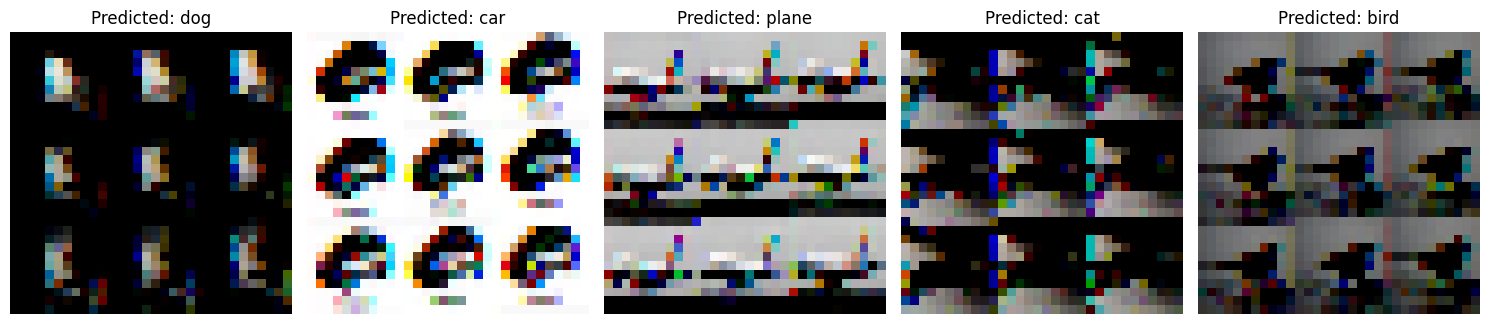

In [ ]:
# Reshape the images and select the first 5
images_to_display = X_train_n[:, :6].T.reshape(-1, 32, 32, 3)

# Make predictions for each image
predictions = nn_model.predict(X_train_n[:, :6])

# Create a grid of subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
  # Display the image
  axes[i].imshow((images_to_display[i][:, :]))
  axes[i].set_title(f"Predicted: {classes[predictions[i]]}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()

2: Implement CNN using PyTorch

In [ ]:
 #2 CNN using Pytorch

 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 print(f"Using device: {device}")

Using device: cuda


In [ ]:
#Loading the CIFAR10 Dataset for the pytorch implementation of CNN
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))]
)

batch_size = 16

whole_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform=transform)
#Spliting the traning dataset into 90% (training data) and 10% (Validation Data)
trainset, valset = torch.utils.data.random_split(whole_trainset, [45000, 5000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=True, num_workers=2 )

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                        transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False,
                                          num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Initializing the First CNN Model

class Cnn_Model_1(nn.Module):
  def __init__(self):
    super(Cnn_Model_1, self).__init__()

    # 1st Convolutional Layer
    self.Con_1 = nn.Conv2d(3,32,5)
    self.b_norm_1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2,2)

    # 2nd Convolutional Layer
    self.Con_2 = nn.Conv2d(32,64,5)
    self.b_norm_2 = nn.BatchNorm2d(64)

    # 3rd Convolutional Layer
    self.Con_3 = nn.Conv2d(64,128,3)
    self.b_norm_3 = nn.BatchNorm2d(128)

    # Calculating o/p size for the last layer
    self.fc1 = nn.Linear(128 * 3 *3, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

    #Defining the Dropout layer
    self.do_layer = nn.Dropout(0.5)


  def forward(self, x):
    x = self.Con_1(x)
    x = self.b_norm_1(x)
    x = F.relu(x)
    x = self.pool(x)

    x = self.Con_2(x)
    x = self.b_norm_2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = self.Con_3(x)
    x = self.b_norm_3(x)
    x = F.relu(x)

    x = x.view(-1, 128 * 3 * 3)
    x = F.relu(self.fc1(x))
    x = self.do_layer(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


In [ ]:
# Initializing the Second CNN Model

class Cnn_Model_2(nn.Module):
  def __init__(self):
    super(Cnn_Model_2, self).__init__()

    self.conv_layer = nn.Sequential(
        #1
        nn.Conv2d(3,32,5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2),

        #2
        nn.Conv2d(32,64,5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2),

        #3
        nn.Conv2d(64,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2,2),

        #4
        nn.Conv2d(128,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
    )

    # Initilize the weights to calculate the oput size of the layer
    self.to_linear = None
    self._initialize_weights()

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(self.to_linear, 512),
        nn.ReLU(inplace = True),
        nn.Linear(512, 256),
        nn.ReLU(inplace = True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def _initialize_weights(self):
    with torch.no_grad():
      x = torch.zeros(1, 3, 32, 32)
      self.to_linear = self.conv_layer(x).numel()


  def forward(self, x):
    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)
    return x


In [ ]:
def accuracy(loader, model):
  crt = 0
  T = 0
  model.eval()
  with torch.no_grad():
    for data in loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      T = T + labels.size(0)
      crt = crt + (predicted == labels).sum().item()
      acc = 100 * crt / T
  return acc

In [ ]:
def train_cnn(model, train_loader, val_loader, optimizer, loss_func, epoch, device):
  model.to(device)
  for epoch_n in range(epoch):
    current_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      current_loss = current_loss + loss.item()

      if i % 100 == 99:
        print(f"Epoch {epoch_n + 1}    Batch{i + 1}    Loss {current_loss / 100 : .3f}")
        current_loss = 0.0

    training_accuracy = accuracy(train_loader, model)
    print(f"Training Accuracy for the epoch {epoch_n + 1}: {training_accuracy: .2f}%")

    validation_accuracy = accuracy(val_loader, model)
    print(f"Validation Accuracy for the epoch {epoch_n + 1}: {validation_accuracy: .2f}%")


  print("This model is Trained!")

In [ ]:
Cnn = Cnn_Model_1()

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(Cnn.parameters(), lr = 0.001, momentum=0.9)
epoch = 10

train_cnn(Cnn, trainloader, valloader, optimizer, loss_func, epoch, device=device)

Epoch 1    Batch100    Loss  2.296
Epoch 1    Batch200    Loss  2.239
Epoch 1    Batch300    Loss  2.128
Epoch 1    Batch400    Loss  1.980
Epoch 1    Batch500    Loss  1.859
Epoch 1    Batch600    Loss  1.799
Epoch 1    Batch700    Loss  1.712
Epoch 1    Batch800    Loss  1.693
Epoch 1    Batch900    Loss  1.629
Epoch 1    Batch1000    Loss  1.598
Epoch 1    Batch1100    Loss  1.601
Epoch 1    Batch1200    Loss  1.560
Epoch 1    Batch1300    Loss  1.519
Epoch 1    Batch1400    Loss  1.548
Epoch 1    Batch1500    Loss  1.440
Epoch 1    Batch1600    Loss  1.509
Epoch 1    Batch1700    Loss  1.412
Epoch 1    Batch1800    Loss  1.438
Epoch 1    Batch1900    Loss  1.410
Epoch 1    Batch2000    Loss  1.378
Epoch 1    Batch2100    Loss  1.399
Epoch 1    Batch2200    Loss  1.419
Epoch 1    Batch2300    Loss  1.366
Epoch 1    Batch2400    Loss  1.402
Epoch 1    Batch2500    Loss  1.294
Epoch 1    Batch2600    Loss  1.316
Epoch 1    Batch2700    Loss  1.301
Epoch 1    Batch2800    Loss  1.254
T

In [ ]:
Cnn_2 = Cnn_Model_2()

loss_func_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(Cnn_2.parameters(), lr = 0.001)
epoch = 10

train_cnn(Cnn_2, trainloader, valloader, optimizer_2, loss_func_2, epoch, device=device)

Epoch 1    Batch100    Loss  2.110
Epoch 1    Batch200    Loss  1.900
Epoch 1    Batch300    Loss  1.786
Epoch 1    Batch400    Loss  1.733
Epoch 1    Batch500    Loss  1.722
Epoch 1    Batch600    Loss  1.641
Epoch 1    Batch700    Loss  1.578
Epoch 1    Batch800    Loss  1.616
Epoch 1    Batch900    Loss  1.556
Epoch 1    Batch1000    Loss  1.532
Epoch 1    Batch1100    Loss  1.511
Epoch 1    Batch1200    Loss  1.435
Epoch 1    Batch1300    Loss  1.515
Epoch 1    Batch1400    Loss  1.407
Epoch 1    Batch1500    Loss  1.417
Epoch 1    Batch1600    Loss  1.391
Epoch 1    Batch1700    Loss  1.365
Epoch 1    Batch1800    Loss  1.407
Epoch 1    Batch1900    Loss  1.374
Epoch 1    Batch2000    Loss  1.308
Epoch 1    Batch2100    Loss  1.305
Epoch 1    Batch2200    Loss  1.295
Epoch 1    Batch2300    Loss  1.272
Epoch 1    Batch2400    Loss  1.329
Epoch 1    Batch2500    Loss  1.247
Epoch 1    Batch2600    Loss  1.233
Epoch 1    Batch2700    Loss  1.261
Epoch 1    Batch2800    Loss  1.242
T

In [ ]:
def test_cnn(model, test_loader, loss_func, device):
  model.eval()
  test_loss = 0.0
  class_correct = [0.0] * 10
  class_total = [0.0] * 10

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = loss_func(output, target)
      test_loss = test_loss + loss.item() * data.size(0)
      _, pred = torch.max(output, 1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = correct_tensor.cpu().numpy() if device.type == 'cuda' else correct_tensor.numpy()

      for i in range(target.size(0)):
        label = target.data[i].item()
        class_correct[label] = class_correct[label] + correct[i].item()
        class_total[label] = class_total[label] + 1

  test_loss = test_loss/len(test_loader.dataset)
  print("Test loss value: {:.5f}\n".format(test_loss))

  for i in range(10):
    if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                class_correct[i], class_total[i]))
    else:
      print("Test Accuracy of %5s: not found" % (classes[i]))

  return test_loss, class_correct, class_total


In [ ]:
test_loss_Cnn,class_correct_Cnn,class_total_Cnn = test_cnn(Cnn, testloader, loss_func, device)
test_loss_Cnn_2,class_correct_Cnn_2,class_total_Cnn_2 = test_cnn(Cnn_2, testloader, loss_func, device)

avg_accuracy_Cnn = sum(class_correct_Cnn) / sum(class_total_Cnn) * 100
avg_accuracy_Cnn_2 = sum(class_correct_Cnn_2) / sum(class_total_Cnn_2) * 100

print(f"Overall Accuracy on CNN Modal_1 is: {avg_accuracy_Cnn: .3f}%")
print(f"Overall Accuracy on CNN Modal_2 is: {avg_accuracy_Cnn_2: .3f}%")



Test loss value: 1.01782

Test Accuracy of plane: 77% (778/1000)
Test Accuracy of   car: 86% (865/1000)
Test Accuracy of  bird: 71% (710/1000)
Test Accuracy of   cat: 55% (553/1000)
Test Accuracy of  deer: 56% (567/1000)
Test Accuracy of   dog: 64% (645/1000)
Test Accuracy of  frog: 77% (775/1000)
Test Accuracy of horse: 77% (776/1000)
Test Accuracy of  ship: 70% (700/1000)
Test Accuracy of truck: 72% (726/1000)
Test loss value: 0.98692

Test Accuracy of plane: 80% (809/1000)
Test Accuracy of   car: 84% (842/1000)
Test Accuracy of  bird: 62% (626/1000)
Test Accuracy of   cat: 59% (599/1000)
Test Accuracy of  deer: 76% (766/1000)
Test Accuracy of   dog: 65% (653/1000)
Test Accuracy of  frog: 79% (792/1000)
Test Accuracy of horse: 80% (807/1000)
Test Accuracy of  ship: 82% (820/1000)
Test Accuracy of truck: 86% (862/1000)
Overall Accuracy on CNN Modal_1 is:  70.950%
Overall Accuracy on CNN Modal_2 is:  75.760%


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))


In [ ]:
def predict_image_labels(test_loader, model):
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  images = images.to(device)
  outputs = model(images)
  _, predicted = torch.max(outputs, 1)

  return images, predicted

Predict Labels for Model 1: [3 8 1 0 4 6 9 2 3 1 0 9 5 7 9 8 5 3 8 6 7 2 4 9 4 3 4 0 9 6 6 2 2 5 9 8 7
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 0 7 3 8 8 7 5 5 5 7 5 6 5]


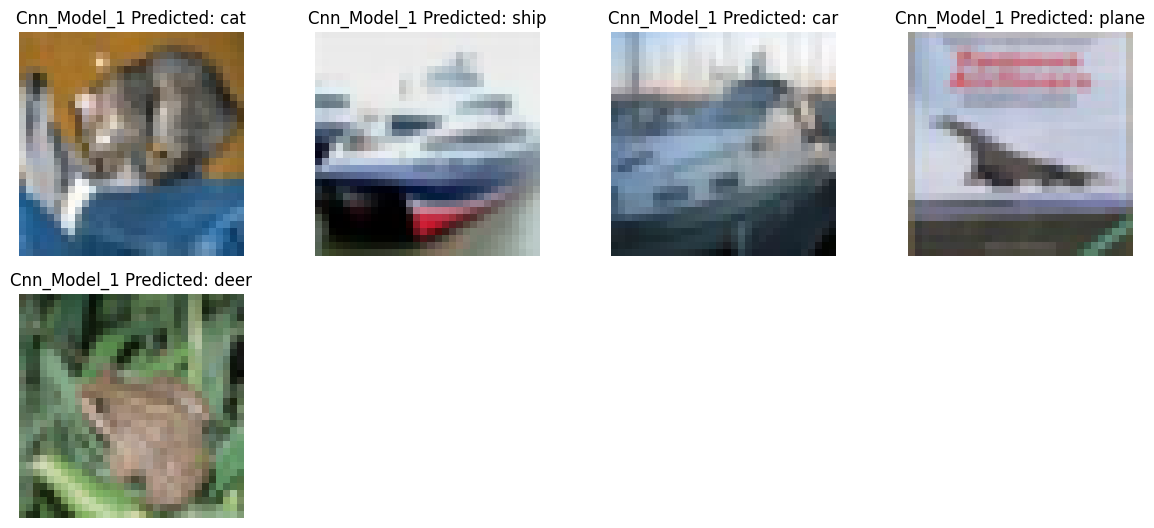

In [ ]:
image = 5
def display_predictions(images, predicted, model, image):
  plt.figure(figsize=(12,8))

  for i in range(min(image, len(images))):
    plt.subplot(3,4,i + 1)
    imshow(images[i].cpu())
    plt.title(f"{model} Predicted: {classes[predicted[i].item()]}")
    plt.axis('off')
  plt.tight_layout()
  plt.axis()


images_cnn, predicted_cnn = predict_image_labels(testloader, Cnn)
print("Predict Labels for Model 1:", predicted_cnn.cpu().numpy())
display_predictions(images_cnn, predicted_cnn, "Cnn_Model_1", image = 5)

Predict Labels for Model 2: [3 8 8 0 6 6 1 6 3 9 0 9 5 7 9 8 5 7 8 6 4 0 0 9 4 2 3 0 9 6 6 5 2 2 9 8 4
 1 9 5 4 6 3 6 0 9 3 3 7 6 9 8 7 3 8 8 7 3 3 7 7 3 6 3]


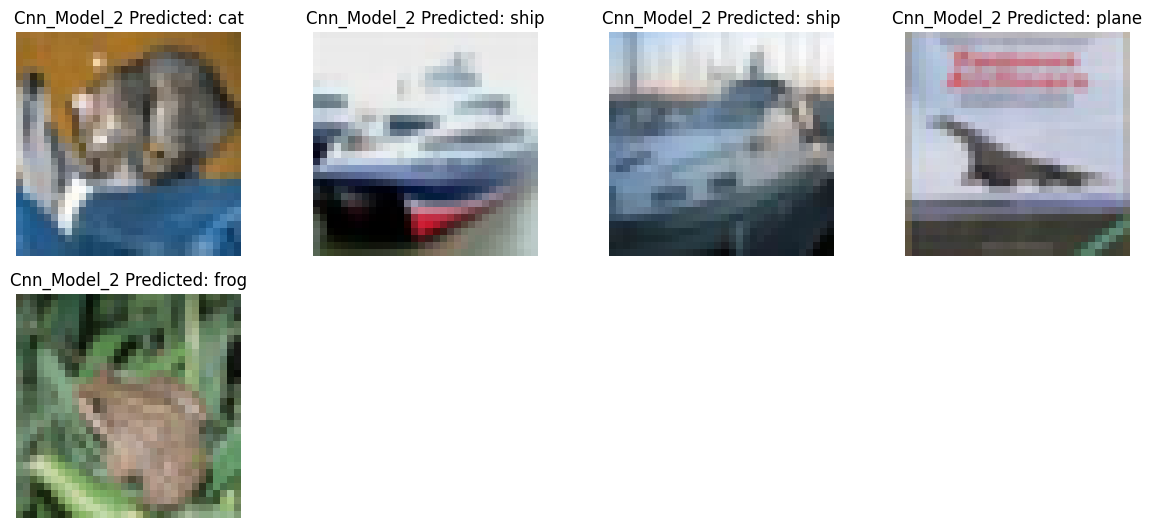

In [ ]:
images_cnn_2, predicted_cnn_2 = predict_image_labels(testloader, Cnn_2)
print("Predict Labels for Model 2:", predicted_cnn_2.cpu().numpy())
display_predictions(images_cnn_2, predicted_cnn_2, "Cnn_Model_2", image = 5)

## Conclusion:

**CNN-1:**
This model is made using 3 layers,in which we have used a single dropout layer only after the first fully connected layer. Also we have use SGD optimizer for training the training data.

**CNN-2:**In this model is alos made using 3 fully connected layers, but in this model we have applied dropout layer after both the first connected layer and second fully connected layer. For this model we have used Adam optimizer for trainning the dataset. Cnn_Model_2 contains the function named _initialize_weights to calculate output size of the convolutional layers, which is used to define the input size of the first fully connected layer which contributes in increasing the overall accuracy.

<h6>References</h6>
<h5>1) https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</h5>
<h5>2)https://www.pythonpool.com/convert-tensor-to-numpy-array/</h5>
<h5>3) https://stackoverflow.com/questions/22426609/shuffle-a-numpy-array </h5>
<h5>4) https://medium.com/@waleedmousa975/building-a-neural-network-from-scratch-using-numpy-and-math-libraries-a-step-by-step-tutorial-in-608090c20466</h5>
<h5>5) https://rileylearning.medium.com/affine-layer-6b7163a2da65</h5>
<h5>6) https://www.deepchecks.com/glossary/rectified-linear-unit-relu/#:~:text=ReLU%20formula%20is%20%3A%20f(x,range%20of%200%20to%20infinite.</h5>
<h5>7) https://gurjeet333.medium.com/7-best-techniques-to-improve-the-accuracy-of-cnn-w-o-overfitting-6db06467182f</h5>
<h5>8)https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/</h5>
<h5>9) https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844</h5>